In [1]:
import numpy as np
from numpy import percentile
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings("ignore")
from sklearn.datasets import make_moons, make_blobs

In [2]:
from src.LSHiForest.detectors import VSSampling
from src.LSHiForest.detectors import Bagging
from src.LSHiForest.detectors import LSHForest
from src.LSHiForest.detectors import E2LSH, KernelLSH, AngleLSH

rng = np.random.RandomState(42)
num_ensemblers = 100
classifiers = [("ALSH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), AngleLSH())),
               ("L1SH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), E2LSH(norm=1))),
               ("L2SH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), E2LSH(norm=2))),
               ("KLSH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), KernelLSH()))]

In [3]:
# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_outliers:] = 1

blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, 0.3], **blobs_params)[0],
    4
    * (
        make_moons(n_samples=n_samples, noise=0.05, random_state=0)[0]
        - np.array([0.5, 0.25])
    ),
]

In [4]:
# Show the statics of the data
print("Number of inliers: %i" % n_inliers)
print("Number of outliers: %i" % n_outliers)
print(
    "Ground truth shape is {shape}. Outlier are 1 and inliers are 0.\n".format(
        shape=ground_truth.shape
    )
)
print(ground_truth)

Number of inliers: 255
Number of outliers: 45
Ground truth shape is (300,). Outlier are 1 and inliers are 0.

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


  0%|          | 0/4 [00:00<?, ?it/s]

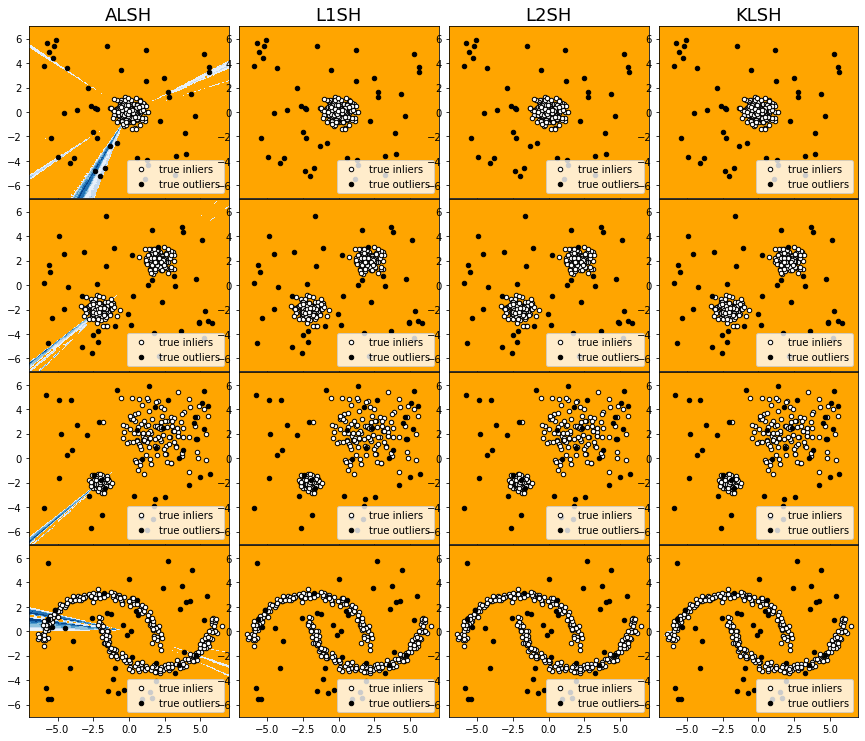

In [5]:
xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))
plt.figure(figsize=(len(classifiers) * 2 + 4, 10))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(tqdm(datasets)):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

    for i_alg, (alg_name, algorithm) in enumerate(classifiers):
        algorithm.fit(X)
        scores_pred = algorithm.decision_function(X) * -1

        # y_pred = algorithm.predict(X)
        threshold = percentile(scores_pred, 100 * outliers_fraction)

        # plot the levels lines and the points
        Z = algorithm.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
        Z = Z.reshape(xx.shape)

        subplot = plt.subplot(len(datasets), len(classifiers), plot_num)
        if i_dataset == 0:
            plt.title(alg_name, size=18)
        subplot.contourf(
            xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r
        )
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors="orange")
        b = subplot.scatter(
            X[:-n_outliers, 0], X[:-n_outliers, 1], c="white", s=20, edgecolor="k"
        )
        c = subplot.scatter(
            X[-n_outliers:, 0], X[-n_outliers:, 1], c="black", s=20, edgecolor="k"
        )
        subplot.axis("tight")
        subplot.legend(
            [b, c],
            ["true inliers", "true outliers"],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc="lower right",
        )
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))

        plot_num += 1

plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

0 ALSH: 0.46653594771241824
0 L1SH: 0.9994771241830066
0 L2SH: 1.0
0 KLSH: 0.9731590413943355
1 ALSH: 0.9313725490196078
1 L1SH: 0.9969498910675382
1 L2SH: 0.9988671023965141
1 KLSH: 0.961917211328976
2 ALSH: 0.8408714596949891
2 L1SH: 0.8993464052287582
2 L2SH: 0.901437908496732
2 KLSH: 0.8109803921568628


ValueError: Found input variables with inconsistent numbers of samples: [300, 345]

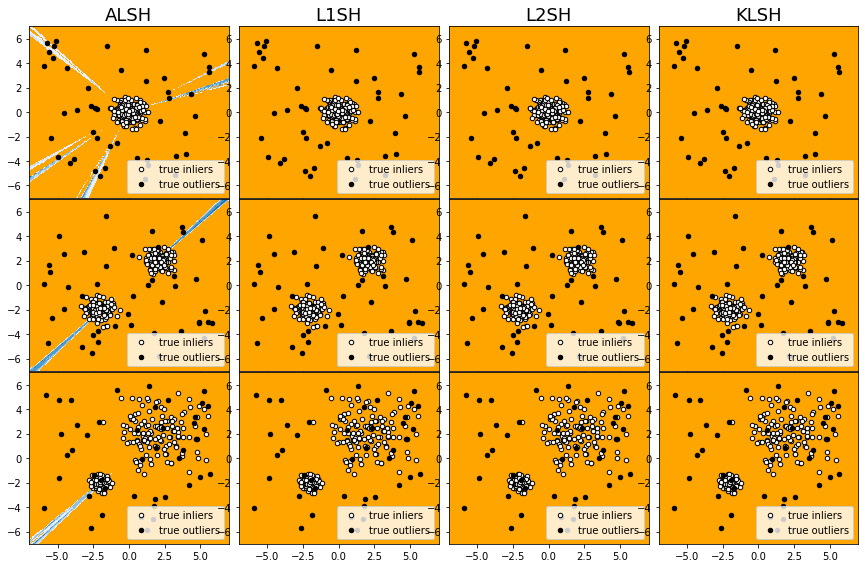

In [8]:
from sklearn.metrics import roc_auc_score

xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))
plt.figure(figsize=(len(classifiers) * 2 + 4, 10))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(tqdm(datasets)):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

    for i_alg, (alg_name, algorithm) in enumerate(classifiers):
        algorithm.fit(X)
        scores_pred = algorithm.decision_function(X) * -1
        
        #AUC
        y_pred = scores_pred.ravel()
        auc = roc_auc_score(ground_truth, y_pred)
        print(i_dataset, alg_name + ":", auc)
        


        # y_pred = algorithm.predict(X)
        threshold = percentile(scores_pred, 100 * outliers_fraction)

        # plot the levels lines and the points
        Z = algorithm.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
        Z = Z.reshape(xx.shape)

        subplot = plt.subplot(len(datasets), len(classifiers), plot_num)
        if i_dataset == 0:
            plt.title(alg_name, size=18)
        subplot.contourf(
            xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r
        )
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors="orange")
        b = subplot.scatter(
            X[:-n_outliers, 0], X[:-n_outliers, 1], c="white", s=20, edgecolor="k"
        )
        c = subplot.scatter(
            X[-n_outliers:, 0], X[-n_outliers:, 1], c="black", s=20, edgecolor="k"
        )
        subplot.axis("tight")
        subplot.legend(
            [b, c],
            ["true inliers", "true outliers"],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc="lower right",
        )
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))

        plot_num += 1

plt.show()

sklearn.ISO_AUC: 0.7801867911941294
sklearn.ISO_PR: 0.19466186938843685
[-0.01283458  0.0008741  -0.00497992 ... -0.00411792  0.02453677
  0.10015033]
[[0.19662302 0.19662302 0.19662302 ... 0.1649922  0.1649922  0.1649922 ]
 [0.19662302 0.19662302 0.19662302 ... 0.1649922  0.1649922  0.1649922 ]
 [0.19662302 0.19662302 0.19662302 ... 0.1649922  0.1649922  0.1649922 ]
 ...
 [0.18548926 0.18548926 0.18548926 ... 0.18206704 0.18206704 0.18206704]
 [0.18548926 0.18548926 0.18548926 ... 0.18206704 0.18206704 0.18206704]
 [0.18548926 0.18548926 0.18548926 ... 0.18206704 0.18206704 0.18206704]]
-0.03650029763170182 -0.03630676005070189 0.19662302495860318
ALSH_AUC: 0.6222898599066045
ALSH_PR: 0.13229042803340854
[0.15537543 0.15427863 0.15495111 ... 0.15320171 0.15198135 0.17618391]
[[0.40090151 0.40090151 0.40090151 ... 0.21066596 0.20512059 0.1968866 ]
 [0.40090151 0.40090151 0.40090151 ... 0.20512059 0.1968866  0.19629663]
 [0.39661982 0.40090151 0.40090151 ... 0.1968866  0.19629663 0.1932

ValueError: Contour levels must be increasing

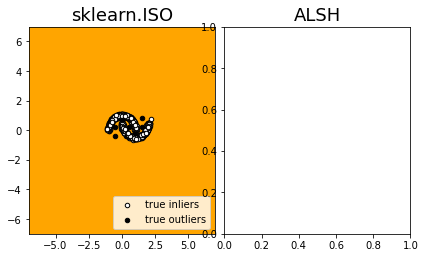

In [28]:
import numpy as np
from numpy import percentile
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.ensemble import IsolationForest

from src.LSHiForest.detectors import VSSampling
from src.LSHiForest.detectors import Bagging
from src.LSHiForest.detectors import LSHForest
from src.LSHiForest.detectors import E2LSH, KernelLSH, AngleLSH

rng = np.random.RandomState(42)
num_ensemblers = 100

data = pd.read_csv('datasets/Moon.csv', header=None)
X = data.values[:, :-1].tolist()
ground_truth = data.values[:, -1].tolist()
n_outliers = 7
n_sample = len(X)
outliers_fraction = n_outliers/n_sample

classifiers = [("sklearn.ISO", IsolationForest(random_state=rng, n_estimators=100)),
               ("ALSH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), AngleLSH())),
               ("L1SH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), E2LSH(norm=1))),
               ("L2SH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), E2LSH(norm=2))),
               ("KLSH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), KernelLSH()))]


xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))
plt.figure(figsize=(len(classifiers)*2+4, 3))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)


for i_alg, (alg_name, algorithm) in enumerate(classifiers):
    algorithm.fit(X)
    scores_pred = algorithm.decision_function(X) * -1

    #AUC
    y_pred = scores_pred.ravel()
    auc = roc_auc_score(ground_truth, y_pred)
    pr_auc = average_precision_score(ground_truth, y_pred)
    print(alg_name + "_AUC:", auc)
    print(alg_name + "_PR:", pr_auc)
    print(scores_pred)

    threshold = percentile(scores_pred, 100 * outliers_fraction)

    # plot the levels lines and the points
    Z = algorithm.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
    print(Z)
    print(Z.min(), threshold, Z.max())

    subplot = plt.subplot(1, len(classifiers), plot_num)
#     if i_dataset == 0:
    plt.title(alg_name, size=18)
    subplot.contourf(
        xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r
    )
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors="orange")
    X=np.array(X)
    b = subplot.scatter(
        X[:-n_outliers, 0], X[:-n_outliers, 1], c="white", s=20, edgecolor="k"
    )
    c = subplot.scatter(
        X[-n_outliers:, 0], X[-n_outliers:, 1], c="black", s=20, edgecolor="k"
    )
    subplot.axis("tight")
    subplot.legend(
        [b, c],
        ["true inliers", "true outliers"],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc="lower right",
    )
    subplot.set_xlim((-7, 7))
    subplot.set_ylim((-7, 7))
    
    plot_num += 1


plt.show()

sklearn.ISO_AUC: 0.7801867911941294
sklearn.ISO_PR: 0.19466186938843685
ALSH_AUC: 0.5884339559706471
ALSH_PR: 0.13166727780081808
L1SH_AUC: 0.9984156104069379
L1SH_PR: 0.8571428571428572
L2SH_AUC: 0.9387925283522349
L2SH_PR: 0.5319338158460876
KLSH_AUC: 0.9997498332221482
KLSH_PR: 0.9659090909090909
OPTiF_AUC: 0.9295363575717145
OPTiF_PR: 0.5002839492108881


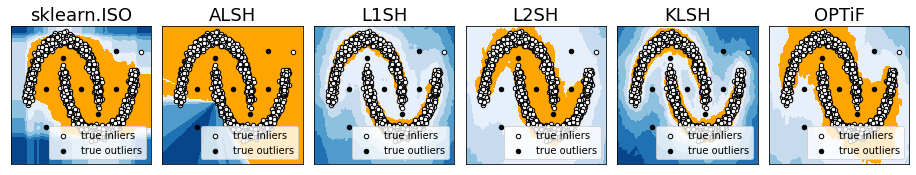

In [27]:
import numpy as np
from numpy import percentile
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.ensemble import IsolationForest

from src.LSHiForest.detectors import VSSampling
from src.LSHiForest.detectors import Bagging
from src.LSHiForest.detectors import LSHForest
from src.LSHiForest.detectors import E2LSH, KernelLSH, AngleLSH

from src.OPTiForest.detectors import OptIForest

rng = np.random.RandomState(42)
num_ensemblers = 100

data = pd.read_csv('datasets/Moon.csv', header=None)
X = data.values[:, :-1].tolist()
ground_truth = data.values[:, -1].tolist()
n_outliers = 7
n_sample = len(X)
outliers_fraction = n_outliers/n_sample

# paramaters of OPTiForest
threshold=403
branch=0

classifiers = [("sklearn.ISO", IsolationForest(random_state=rng, n_estimators=100)),
               ("ALSH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), AngleLSH())),
               ("L1SH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), E2LSH(norm=1))),
               ("L2SH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), E2LSH(norm=2))),
               ("KLSH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), KernelLSH())),
               ("OPTiF", OptIForest('L2OPT', num_ensemblers, threshold, branch))]


xx, yy = np.meshgrid(np.linspace(-2.5, 2.5, 150), np.linspace(-2.5, 2.5, 150))
plt.figure(figsize=(len(classifiers)*2+1, 2))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.08, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)


for i_alg, (alg_name, algorithm) in enumerate(classifiers):
    algorithm.fit(X)
    scores_pred = algorithm.decision_function(X)

    #AUC
    y_pred = scores_pred.ravel()
    auc = roc_auc_score(ground_truth, -1.0 * y_pred)
    pr_auc = average_precision_score(ground_truth, -1.0 * y_pred)
    print(alg_name + "_AUC:", auc)
    print(alg_name + "_PR:", pr_auc)

    threshold = percentile(scores_pred, 2)

    # plot the levels lines and the points
    Z = algorithm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

#     print(Z.min(), threshold, Z.max())

    subplot = plt.subplot(1, len(classifiers), plot_num)
#     if i_dataset == 0:
    plt.title(alg_name, size=18)
    subplot.contourf(
        xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r
    )
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors="orange")
    X=np.array(X)
    b = subplot.scatter(
        X[:-n_outliers, 0], X[:-n_outliers, 1], c="white", s=20, edgecolor="k"
    )
    c = subplot.scatter(
        X[-n_outliers:, 0], X[-n_outliers:, 1], c="black", s=20, edgecolor="k"
    )
    subplot.axis("tight")
    subplot.legend(
        [b, c],
        ["true inliers", "true outliers"],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc="lower right",
    )
    subplot.set_xlim((-1.5, 2.5))
    subplot.set_ylim((-1, 1.2))
    plt.xticks([])
    plt.yticks([])
    
    plot_num += 1


plt.show()

In [ ]:
import numpy as np
from numpy import percentile
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.ensemble import IsolationForest

from src.LSHiForest.detectors import VSSampling
from src.LSHiForest.detectors import Bagging
from src.LSHiForest.detectors import LSHForest
from src.LSHiForest.detectors import E2LSH, KernelLSH, AngleLSH

import eif
from pyod.models.inne import INNE
from src.idkd._idkd_pod import IDKD

from src.OPTiForest.detectors import OptIForest

rng = np.random.RandomState(42)
num_ensemblers = 100

data = pd.read_csv('datasets/Moon.csv', header=None)
X = data.values[:, :-1].tolist()
ground_truth = data.values[:, -1].tolist()
n_outliers = 7
n_sample = len(X)
outliers_fraction = n_outliers/n_sample

# paramaters of OPTiForest
threshold=403
branch=0

# classifiers = [("sklearn.ISO", IsolationForest(random_state=rng, n_estimators=100)),
#                ("EIF", eif.iForest(X, ntrees=num_ensemblers, sample_size=256, ExtensionLevel=1)),
#                ("iNNE", INNE(contamination=outliers_fraction, max_samples=16, random_state=random_state)),
#                ("IDKD", IDKD(contamination=outliers_fraction, max_samples=16, random_state=random_state)),
#                ("ALSH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), AngleLSH())),
#                ("L1SH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), E2LSH(norm=1))),
#                ("L2SH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), E2LSH(norm=2))),
#                ("KLSH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), KernelLSH())),
#                ("OPTiF", OptIForest('L2OPT', num_ensemblers, threshold, branch))]
sample_sizes = [2,4,8,16,32,64]
sample_sizes2 = [32,64,128,256,512,1024]

alg_name = "EIF"
algorithm = eif.iForest(X, ntrees=num_ensemblers, sample_size=256, ExtensionLevel=1)



xx, yy = np.meshgrid(np.linspace(-2.5, 2.5, 150), np.linspace(-2.5, 2.5, 150))
plt.figure(figsize=(len(classifiers)*2+1, 2))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.08, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)


# for i_alg, (alg_name, algorithm) in enumerate(classifiers):
for i in sample_sizes:
    print(i)
    algorithm = eif.iForest(X, ntrees=num_ensemblers, sample_size=i, ExtensionLevel=1)
    algorithm.fit(X)
    scores_pred = algorithm.decision_function(X)

# anomaly score of EIF
#     scores_pred = algorithm.compute_paths(X_in=X)

    #AUC
    y_pred = scores_pred.ravel()
    auc = roc_auc_score(ground_truth, -1.0 * y_pred)
    pr_auc = average_precision_score(ground_truth, -1.0 * y_pred)
    print(alg_name + "_AUC:", auc)
    print(alg_name + "_PR:", pr_auc)

    threshold = percentile(scores_pred, 2)

    # plot the levels lines and the points
    Z = algorithm.decision_function(np.c_[xx.ravel(), yy.ravel()])

# anomaly score of EIF
#     Z = algorithm.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
    
    Z = Z.reshape(xx.shape)

#     print(Z.min(), threshold, Z.max())

    subplot = plt.subplot(1, len(classifiers), plot_num)
#     if i_dataset == 0:
    plt.title(alg_name, size=18)
    subplot.contourf(
        xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r
    )
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors="orange")
    X=np.array(X)
    b = subplot.scatter(
        X[:-n_outliers, 0], X[:-n_outliers, 1], c="white", s=20, edgecolor="k"
    )
    c = subplot.scatter(
        X[-n_outliers:, 0], X[-n_outliers:, 1], c="black", s=20, edgecolor="k"
    )
    subplot.axis("tight")
    subplot.legend(
        [b, c],
        ["true inliers", "true outliers"],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc="lower right",
    )
    subplot.set_xlim((-1.5, 2.5))
    subplot.set_ylim((-1, 1.2))
    plt.xticks([])
    plt.yticks([])
    
    plot_num += 1


plt.show()